In [1]:
from datasets import load_dataset
from pympi import Elan
import os
from glob import glob
import pandas as pd
import numpy as np
os.chdir('/Users/markjos/projects/malachor5')
import sys
sys.path.append('scripts')
from eval import get_word_language
from tokenization_utils import normalize_tira_eng_str
from longform import load_and_resample
from tqdm import tqdm
tqdm.pandas()
import torchaudio

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
elicitation_wav_dir = 'data/elicitation-wavs/wav/'
tira_eval_dir = 'data/hf-datasets/tira-eval/'
eafs = glob('meta/*.eaf')
eafs

['meta/HH20210312.eaf', 'meta/HH20210913.eaf', 'meta/HH20220327-2.eaf']

In [82]:
def convert_eaf_to_pandas(eaf_path):
    eaf = Elan.Eaf(eaf_path)
    data = []
    for tier in eaf.get_tier_names():
        if len(tier)!=3 and not tier.isupper():
            continue
        for annotation in eaf.get_annotation_data_for_tier(tier):
            data.append({
                'tier': tier,
                'file': eaf_path,
                'start': annotation[0],
                'end': annotation[1],
                'duration': annotation[1]-annotation[0],
                'value': annotation[2]
            })
    return pd.DataFrame(data)

In [83]:
df_list=[]
for eaf_fp in eafs:
    # skip noisy recording
    if '20240424' in eaf_fp:
        continue
    df_list.append(convert_eaf_to_pandas(eaf_fp))
df = pd.concat(df_list)
df['duration_min']=df['duration']/60000
df.head()

,tier,file,start,end,duration,value,duration_min
0,SHA,meta/HH20210312.eaf,10340,13050,2710,"Alright, we got it set up.",0.045167
1,SHA,meta/HH20210312.eaf,23170,26460,3290,Ok we ready? So you can stop sharing.,0.054833
2,SHA,meta/HH20210312.eaf,44260,64300,20040,"Now I just have to, alright, so now I'm re-rec...",0.334000
3,SHA,meta/HH20210312.eaf,72560,72780,220,-pulled them,0.003667
4,SHA,meta/HH20210312.eaf,96470,98280,1810,"And can you add ""ùnɛ́ɾɛ́"" after it?",0.030167


In [110]:
get_pct_lang = lambda s, lang: [get_word_language(w) for w in s.split()].count(lang)/len(s.split()) if s.split() else 0
get_pct_tira = lambda s: get_pct_lang(s, 'tira')
get_pct_eng = lambda s: get_pct_lang(s, 'eng')
get_pct_misc = lambda s: get_pct_lang(s, 'misc')

df['pct_tira']=df['value'].apply(get_pct_tira)
df['pct_eng']=df['value'].apply(get_pct_eng)
df['pct_misc']=df['value'].apply(get_pct_misc)

In [85]:
df['codeswitched'] = True
df.loc[
    (df['pct_tira']==0)|(df['pct_eng']==0), 'codeswitched'
] = False
df['matrix_language'] = 'eng'
df.loc[
    (df['pct_tira']>df['pct_eng']), 'matrix_language'
] = 'tira'

In [86]:
df['codeswitched'].value_counts()

codeswitched
False    1673
True      334
Name: count, dtype: int64

In [87]:
df.pivot_table(index=['matrix_language', 'codeswitched'], aggfunc='count')

duration  duration_min   end  file  pct_eng  \
matrix_language codeswitched                                                
eng             False             1375          1375  1375  1375     1375   
                True               274           274   274   274      274   
tira            False              298           298   298   298      298   
                True                60            60    60    60       60   

                              pct_misc  pct_tira  start  tier  value  
matrix_language codeswitched                                          
eng             False             1375      1375   1375  1375   1375  
                True               274       274    274   274    274  
tira            False              298       298    298   298    298  
                True                60        60     60    60     60

In [88]:
df.pivot_table(
    index=['file',],
    values=['pct_eng', 'pct_tira', 'duration_min'],
    aggfunc={'pct_eng': 'mean', 'pct_tira': 'mean', 'duration_min': 'sum'},
)

,duration_min,pct_eng,pct_tira
file,,,
meta/HH20210312.eaf,21.040517,0.685613,0.123367
meta/HH20210913.eaf,22.173100,0.725026,0.233066
meta/HH20220327-2.eaf,35.313800,0.712899,0.228862


In [89]:
df['split']='test'
df.loc[df['file']=='meta/HH20210913.eaf', 'split']='validation'
df['split'].value_counts()

split
test          1385
validation     622
Name: count, dtype: int64

In [90]:
df['duration'].cumsum()

0         2710
1         6000
2        26040
3        26260
4        28070
        ...   
851    4699994
852    4704369
853    4707716
854    4708743
855    4711645
Name: duration, Length: 2007, dtype: int64

In [195]:
# make records of up to 20s by concatenating adjacent records
df=df.reset_index(drop=True)
df['record']=0
df['long_start']=np.nan
df['long_end']=np.nan
df=df.sort_values('start')
for file in tqdm(df['file'].unique()):
    file_mask = df['file']==file
    # print(df.loc[file_mask,'cumul_duration'].max())
    record = df['record'].max()+1
    start = df.loc[file_mask,'start'].iloc[0]
    end = df.loc[file_mask,'end'].iloc[0]
    new_end = end
    final_idx = df[file_mask].index[-1]
    for i, row in tqdm(df[file_mask].iterrows(), total=len(df[file_mask])):
        new_end = row['end']
        if new_end-start>20_000:
            record_mask = df['record']==record
            df.loc[record_mask&file_mask, 'long_start'] = start
            df.loc[record_mask&file_mask, 'long_end'] = end

            record += 1
            assert df.at[row.name, 'record'].item() == 0
            df.at[row.name, 'record'] = record
            start = row['start']
            end = new_end
        else:
            df.at[row.name, 'record'] = record
            end = new_end

        if row.name==final_idx:
            record_mask = df['record']==record
            df.loc[record_mask&file_mask, 'long_start'] = start
            df.loc[record_mask&file_mask, 'long_end'] = end
df['long_duration'] = df['long_end']-df['long_start']
df['record'].describe()

100%|██████████| 3/3 [00:00<00:00,  3.35it/s]


count    2007.000000
mean      186.394619
std       100.210246
min         1.000000
25%       106.000000
50%       182.000000
75%       269.500000
max       364.000000
Name: record, dtype: float64

In [196]:
(df['long_duration']/1_000).describe()

count    2007.000000
mean       17.360226
std         2.859381
min         0.900000
25%        16.139000
50%        18.365000
75%        19.320000
max        20.966000
Name: long_duration, dtype: float64

In [197]:
long_df = df.groupby(
    ['file', 'record']
).agg({
    'long_duration': 'first',
    'long_start': 'first',
    'long_end': 'first',
    'value': lambda l: ' '.join(l),
    'split': 'first',
})
long_df

long_duration  long_start   long_end  \
file                  record                                         
meta/HH20210312.eaf   1             18050.0       450.0    18500.0   
                      2             18370.0     18630.0    37000.0   
                      3             20040.0     44260.0    64300.0   
                      4              9910.0     64350.0    74260.0   
                      5              3090.0     95630.0    98720.0   
...                                     ...         ...        ...   
meta/HH20220327-2.eaf 360           16195.0   3032319.0  3048514.0   
                      361           19958.0   3049319.0  3069277.0   
                      362           16958.0   3069319.0  3086277.0   
                      363           19625.0   3087055.0  3106680.0   
                      364           14458.0   3108027.0  3122485.0   

                                                                          value  \
file                  record                                                      
meta/HH20210312.eaf   1       Hello hello hello? Oh, this is a very big volu...   
                      2       Sorry? Yeah we wanna share now. We can go ahea...   
                      3       Now I just have to, alright, so now I'm re-rec...   
                      4       He pulled them towards, ok, he pulled them tow...   
                      5               And can you add "ùnɛ́ɾɛ́" after it? Yes.   
...                                                                         ...   
meta/HH20220327-2.eaf 360     This is so helpful, thank you Himidan, I know ...   
                      361     But it's, it's because of the theory, it's stu...   
                      362     I leave on the 10th, the 10th is Sunday? Next ...   
                      363     Friday, yes, next week is gonna, be, wait. Tha...   
                      364     Anyways, I'll add an extra fifteen minutes ont...   

                             split  
file                  record        
meta/HH20210312.eaf   1       test  
                      2       test  
                      3       test  
                      4       test  
                      5       test  
...                            ...  
meta/HH20220327-2.eaf 360     test  
                      361     test  
                      362     test  
                      363     test  
                      364     test  

[364 rows x 5 columns]

In [198]:
long_df['pct_tira']=long_df['value'].apply(get_pct_tira)
long_df['pct_eng']=long_df['value'].apply(get_pct_eng)
long_df['pct_misc']=long_df['value'].apply(get_pct_misc)
long_df['word_count']=long_df['value'].apply(lambda s: len(s.split()))
long_df['codeswitched'] = True
long_df.loc[
    (long_df['pct_tira']==0)|(long_df['pct_eng']==0), 'codeswitched'
] = False
long_df['matrix_language'] = 'eng'
long_df.loc[
    (long_df['pct_tira']>long_df['pct_eng']), 'matrix_language'
] = 'tira'
long_df.pivot_table(index=['matrix_language', 'codeswitched'], aggfunc='count')

long_duration  long_end  long_start  pct_eng  \
matrix_language codeswitched                                                 
eng             False                   106       106         106      106   
                True                    234       234         234      234   
tira            False                     4         4           4        4   
                True                     20        20          20       20   

                              pct_misc  pct_tira  split  value  word_count  
matrix_language codeswitched                                                
eng             False              106       106    106    106         106  
                True               234       234    234    234         234  
tira            False                4         4      4      4           4  
                True                20        20     20     20          20

In [199]:
long_df.pivot_table(
    index=['file',],
    values=['pct_eng', 'pct_tira', 'long_duration', 'value', 'word_count'],
    aggfunc={'pct_eng': 'mean', 'pct_tira': 'mean', 'long_duration': 'sum', 'value': 'count', 'word_count': 'mean'},
)

,long_duration,pct_eng,pct_tira,value,word_count
file,,,,,
meta/HH20210312.eaf,1718415.0,0.879037,0.069297,109,26.917431
meta/HH20210913.eaf,1722086.0,0.833802,0.118581,99,36.414141
meta/HH20220327-2.eaf,2639582.0,0.744136,0.206078,156,35.070513


In [200]:
long_df=long_df.reset_index(drop=True)
long_df.head()

,file,record,long_duration,long_start,long_end,value,split,pct_tira,pct_eng,pct_misc,word_count,codeswitched,matrix_language
0,meta/HH20210312.eaf,1,18050.0,450.0,18500.0,"Hello hello hello? Oh, this is a very big volu...",test,0.000000,0.972222,0.027778,36,False,eng
1,meta/HH20210312.eaf,2,18370.0,18630.0,37000.0,Sorry? Yeah we wanna share now. We can go ahea...,test,0.000000,0.880952,0.119048,42,False,eng
2,meta/HH20210312.eaf,3,20040.0,44260.0,64300.0,"Now I just have to, alright, so now I'm re-rec...",test,0.000000,0.944444,0.055556,36,False,eng
3,meta/HH20210312.eaf,4,9910.0,64350.0,74260.0,"He pulled them towards, ok, he pulled them tow...",test,0.111111,0.833333,0.055556,18,True,eng
4,meta/HH20210312.eaf,5,3090.0,95630.0,98720.0,"And can you add ""ùnɛ́ɾɛ́"" after it? Yes.",test,0.125000,0.875000,0.000000,8,True,eng


In [222]:
# long_df.pivot_table(values='split', index='file', aggfunc='count')
long_df.pivot_table(values='long_duration', index='split', aggfunc='sum', columns=['codeswitched'])/60_000

codeswitched,False,True
split,,
test,23.383850,49.249433
validation,5.336967,23.364467


In [ ]:
ms_to_frames = lambda ms: int(ms*16)
os.makedirs(os.path.join(tira_eval_dir,'test'), exist_ok=True)
os.makedirs(os.path.join(tira_eval_dir,'validation'), exist_ok=True)

cs_df = long_df[long_df['codeswitched']]

def clip_record(row, wav):
    start_frame = ms_to_frames(row['long_start'])
    end_frame = ms_to_frames(row['long_end'])
    clip = wav[:,start_frame:end_frame]
    split=row['split']
    clip_relpath = os.path.join(split, f"{row['record']}.wav")
    clip_path = os.path.join(tira_eval_dir, clip_relpath)
    torchaudio.save(clip_path, clip, 16_000)
    return clip_relpath

for file in tqdm(cs_df['file'].unique()):
    print(file)
    file_mask = cs_df['file']==file
    split = cs_df.loc[file_mask, 'split'].iloc[0]
    wav_fp = os.path.join(elicitation_wav_dir, os.path.basename(file).replace('.eaf', '.wav'))
    wav = load_and_resample(wav_fp)
    cs_df.loc[file_mask, 'file_name'] = cs_df.loc[file_mask].progress_apply(
        lambda row: clip_record(row, wav),
        axis=1
    )
cs_df.to_csv(os.path.join(tira_eval_dir, 'metadata.csv'))

  0%|          | 0/3 [00:00<?, ?it/s]

meta/HH20210312.eaf



 33%|███▎      | 1/3 [00:04<00:08,  4.35s/it]

meta/HH20210913.eaf



 67%|██████▋   | 2/3 [00:10<00:05,  5.58s/it]

meta/HH20220327-2.eaf



100%|██████████| 3/3 [00:15<00:00,  5.24s/it]


<Axes: >

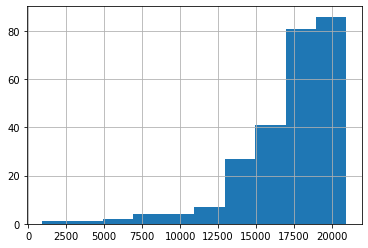

: 

In [228]:
cs_df['long_duration'].hist()#.describe()/1_000

In [220]:
ds=load_dataset('audiofolder', data_dir=tira_eval_dir)
ds

Resolving data files: 100%|██████████| 175/175 [00:00<00:00, 158772.05it/s]
Extracting data files: 0it [00:00, ?it/s]
Extracting data files: 0it [00:00, ?it/s]
Generating validation split: 79 examples [00:00, 1238.71 examples/s]
Generating test split: 175 examples [00:00, 1365.14 examples/s]


DatasetDict({
    validation: Dataset({
        features: ['audio', 'Unnamed: 0', 'file', 'record', 'long_duration', 'long_start', 'long_end', 'value', 'split', 'pct_tira', 'pct_eng', 'pct_misc', 'word_count', 'codeswitched', 'matrix_language'],
        num_rows: 79
    })
    test: Dataset({
        features: ['audio', 'Unnamed: 0', 'file', 'record', 'long_duration', 'long_start', 'long_end', 'value', 'split', 'pct_tira', 'pct_eng', 'pct_misc', 'word_count', 'codeswitched', 'matrix_language'],
        num_rows: 175
    })
})

In [221]:
ds.save_to_disk(tira_eval_dir.replace('hf-datasets', 'pyarrow-datasets'))

Saving the dataset (1/1 shards): 100%|██████████| 175/175 [00:00<00:00, 333.31 examples/s]


In [4]:
df=pd.read_csv(os.path.join(tira_eval_dir,'metadata.csv'),index_col=0)
df.head()

,file,record,long_duration,long_start,long_end,value,split,pct_tira,pct_eng,pct_misc,word_count,codeswitched,matrix_language,file_name
3,meta/HH20210312.eaf,4,9910.0,64350.0,74260.0,"He pulled them towards, ok, he pulled them tow...",test,0.111111,0.833333,0.055556,18,True,eng,test/4.wav
4,meta/HH20210312.eaf,5,3090.0,95630.0,98720.0,"And can you add ""ùnɛ́ɾɛ́"" after it? Yes.",test,0.125000,0.875000,0.000000,8,True,eng,test/5.wav
5,meta/HH20210312.eaf,6,11170.0,118190.0,129360.0,"Ok. And the next one would be ""he pulled them ...",test,0.117647,0.823529,0.058824,17,True,eng,test/6.wav
6,meta/HH20210312.eaf,7,18010.0,138870.0,156880.0,"làŋə̄l What does this mean, sorry? He pulled...",test,0.052632,0.894737,0.052632,19,True,eng,test/7.wav
7,meta/HH20210312.eaf,8,17300.0,166410.0,183710.0,It feels like a high vowel there or something....,test,0.100000,0.900000,0.000000,30,True,eng,test/8.wav


In [8]:
norm_val = df.loc[df['split']=='validation','value'].progress_apply(normalize_tira_eng_str)
norm_val.iloc[:5]

100%|██████████| 79/79 [00:23<00:00,  3.36it/s]


114    okay squirrel in tira is . it is ŋòɽón ŋòɽo...
115    for good yeah i think squirrel is good actuall...
116    and then there is another one that looks i mea...
117    so you can say the . so ŋ̀cɔ́lɔ̀ the word for ...
118    next on the list is . hang on hang on what is ...
Name: value, dtype: object

In [9]:
norm_test = df.loc[df['split']=='test','value'].progress_apply(normalize_tira_eng_str)
norm_test.iloc[:5]

100%|██████████| 175/175 [00:47<00:00,  3.65it/s]


3    he pulled them towards ok he pulled them towar...
4                and can you add ùnɛ́ɾɛ́ after it yes
5    ok and the next one would be he pulled them ye...
6    làŋə̄l what does this mean sorry he pulled th...
7    it feels like a high vowel there or something ...
Name: value, dtype: object

In [10]:
with open(os.path.join(tira_eval_dir, 'validation_transcript.txt'), 'w') as f:
    f.write('\n'.join(norm_val))

with open(os.path.join(tira_eval_dir, 'test_transcript.txt'), 'w') as f:
    f.write('\n'.join(norm_test))